# Comparison of Visualization Methods

Differente visualizations method for the visualization of spatiotemporal data were already developed. However they are not well designed for generate the overview of moving regions. We present the related methods:

- Space Time Cube
- MotionRugs
- SpatialRugs
- "Stable Visual Summaries"
- MotionLines
- "Visual Analysis of Spatio-temporal Phenomena with 1D Projections"

These techniques were applied to the motivating dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
plt.style.use("seaborn-paper")
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Roboto'

import sys
import os
module_path = os.path.abspath(os.path.join('../scripts'))
sys.path.append(module_path)

from rugs_family import MotionRugs, SpatialRugs, MotionLines
from datasets import load_dataset
from projections import hilbert_proj

In [2]:
df = load_dataset("motivating")

## Space-Time Cube

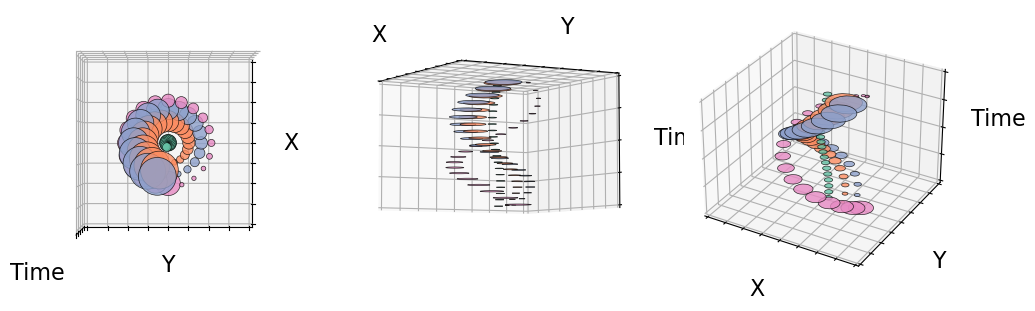

In [4]:
def space_time_cube(df):
    """
    Space-time cube visualization with three different views. Each row in the df is a 
    circle colored with column value "color", the position is the value of the columns 
    ("xcenter", "ycenter", "timestep") and the radius is the value of the column "radius".

    Inputs:
        df - DataFrame with columns ["xcenter", "ycenter", "timestep", "object", "radius", "color"]
    """
    timesteps = df.timestep.max()
    fig = plt.figure(figsize = (12, 4))
    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')
    objects = df.object.unique()
    objects.sort()
    
    if not "color" in df.columns:
        df["color"] = df.object.apply(plt.get_cmap("tab20").__call__)
    
    for (i, row) in df.iterrows():
        x = row['xcenter']
        y = row['ycenter']
        radius = row['radius']
        for ax in [ax1, ax2, ax3]:
            circle = Circle((x, y), radius, color = row["color"], alpha = 0.8, ec = "black", linewidth = 0.5)
            ax.add_patch(circle)
            art3d.pathpatch_2d_to_3d(circle, z= row["timestep"], zdir='z')
    
    # setting ticks and labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('X', fontsize = 16)
        ax.set_ylabel('Y', fontsize = 16)
        ax.set_zlabel('Time', fontsize = 16)
        ax.set_xlim3d(-2, 2)
        ax.set_ylim3d(-2, 2)
        ax.set_zlim3d(0, timesteps)
        ax.set_xticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
        ax.set_yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
        ax.set_zticks([0, 5, 10, 15, 20])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    
    ax1.azim = 0
    ax1.elev = 90
    ax2.elev = -5
    ax2.azim = -30
    
    plt.savefig("plots/space_time_cube.svg", format = "svg", dpi = fig.dpi)
    plt.show()

space_time_cube(df)

## MotionRugs

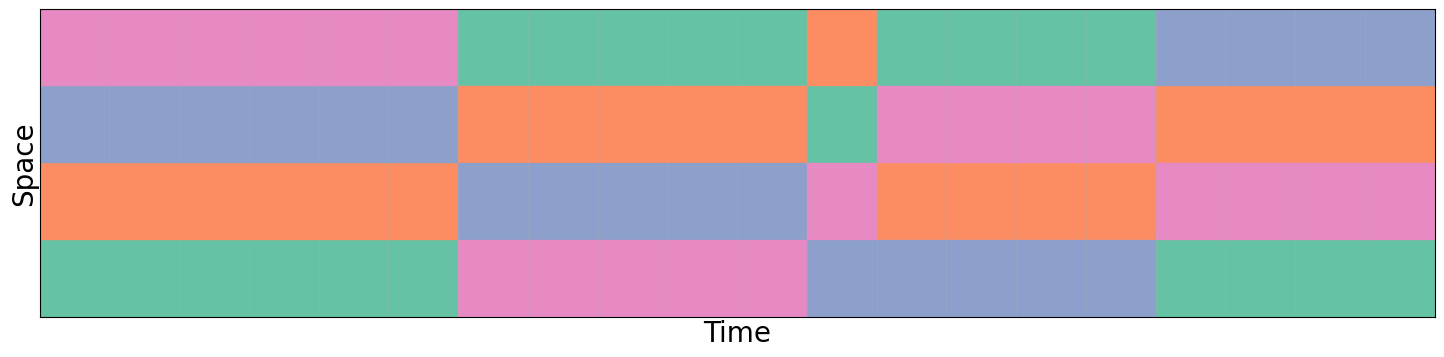

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 4))
MotionRugs(df, ax = ax)
plt.show()

## SpatialRugs

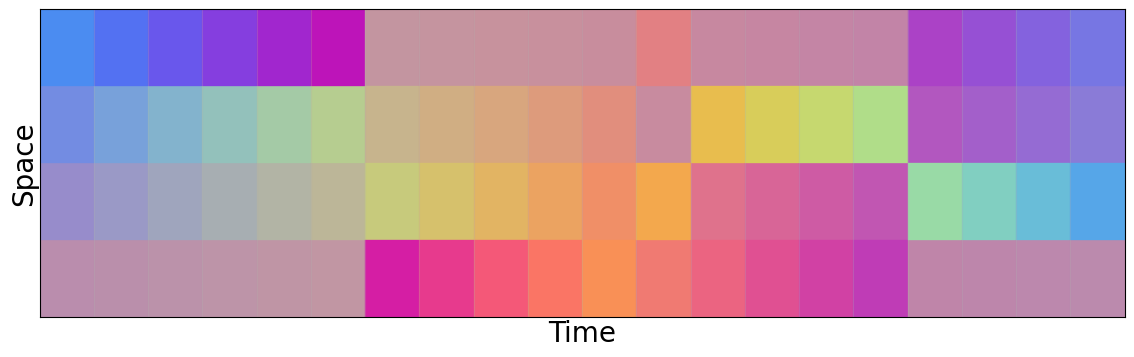

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14, 4))
SpatialRugs(df, ax = ax)
plt.savefig("plots/spatial_rugs.svg")
plt.show()

## Stable Visual Summaries

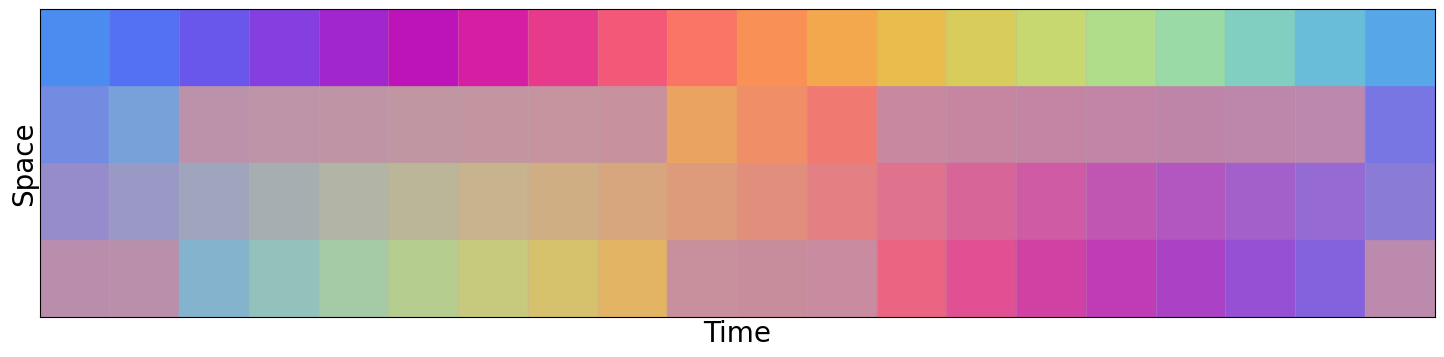

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 4))
SpatialRugs(df, projection_name = "spc", projection_params = {"sigma" : 0.6, "order" : True}, ax = ax)
plt.savefig("plots/stable_visual_summaries.svg")
plt.show()

## MotionLines

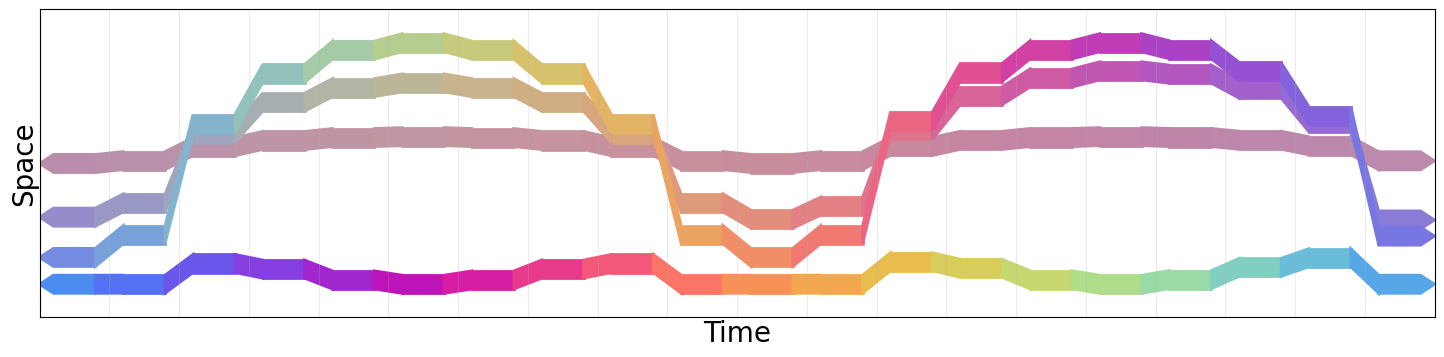

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 4))
MotionLines(df, projection_name = "spc", projection_params = {"sigma" : 0.6}, ax = ax);
plt.savefig("plots/motion_lines.svg")
plt.show()

## Visual Analysis of Spatio-temporal Phenomena with 1D Projections (VASTP)

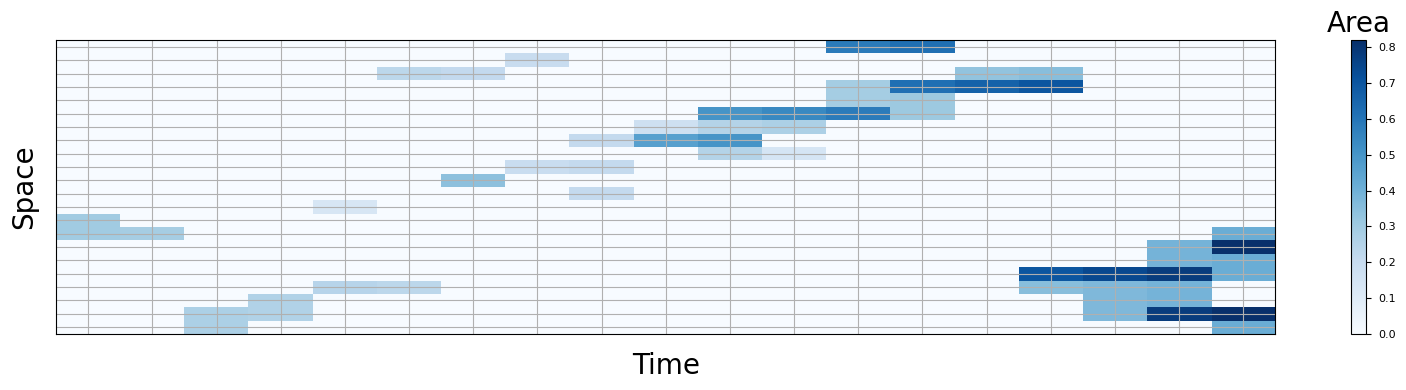

In [9]:
def vastp(df, level = 6):
    """
    Create the main visualization of the paper "Visual Analysis of Spatio-temporal Phenomena with 1D Projections".
    Each row of the DataFrame is considered a circle object. The [-2, 2]² square is divided in a grid of size 10.
    The number of objects in each cell (in each timestep) is computed and represented by the coloring of  the grid cell.

    Inputs:
        df - DataFrame with columns ["xcenter", "ycenter", "timestep", "object", "radius""]
    """ 
    df = df.copy()
    df['x_left'] = df.xcenter - df.radius
    df['x_right'] = df.xcenter + df.radius
    df['y_left'] = df.ycenter - df.radius
    df['y_right'] = df.ycenter + df.radius
    timesteps = df.timestep.max()

    # Separating grid in 10 a 10 square
    # For each timestamp, for each object, the values: 
    vastp_grid_objects_df = {"timestep": [], "xcenter": [], "ycenter": [], "value": [], "object":[]}
    k = 0
    for q1 in range(-20, 20, 4):
        for q2 in range(-20, 20, 4):
            square_boolean = ((df.x_left <= (q1+2)/10) & ((q1+2)/10 <= df.x_right) &
                             (df.y_left <= (q2+2)/10) & ((q2+2)/10 <= df.y_right))
            df_square = df[square_boolean]
            
            for t in range(timesteps):
                vastp_grid_objects_df["timestep"].append(t)
                vastp_grid_objects_df["xcenter"].append(q1/10)
                vastp_grid_objects_df["ycenter"].append(q2/10)
                vastp_grid_objects_df["value"].append(df_square[df_square.timestep == t].radius.sum())
                vastp_grid_objects_df["object"].append(k)  
            k += 1
                
    vastp_grid_objects_df = pd.DataFrame(vastp_grid_objects_df)
    temp = vastp_grid_objects_df.groupby("object").agg({"value": "sum"}).reset_index() 
    positions_with_radius = temp[temp.value > 0].object.values
    vastp_grid_objects_df = vastp_grid_objects_df[vastp_grid_objects_df.object.isin(positions_with_radius)] 
    
    vastp_grid_objects_df = hilbert_proj(vastp_grid_objects_df, level, order = True)
    
    # Creating plot
    M = np.zeros((timesteps, vastp_grid_objects_df.proj.max()))
    
    for i in vastp_grid_objects_df.object.unique():
        cur_df = vastp_grid_objects_df[vastp_grid_objects_df.object == i]
        proj_value = cur_df.proj.iloc[0] - 1
        time_series = cur_df.sort_values("timestep").value.values
        M[:, proj_value] = time_series
        
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 4))
    pcm = ax.imshow(M.T, cmap = matplotlib.cm.get_cmap('Blues'),  interpolation='nearest', aspect='auto')
    ax.grid(True)
    clb = plt.colorbar(pcm, ax = ax)
    clb.ax.set_title('Area', fontsize = 20)

    # ticks and labels
    ax.set_xlabel("Time", fontsize = 20)
    ax.set_ylabel("Space", fontsize = 20)
    ax.set_xticks([i for i in range(M.shape[0])])
    ax.set_yticks([i for i in range(M.shape[1])])
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    ax.tick_params(axis='x', colors=(0,0,0,0))
    ax.tick_params(axis='y', colors=(0,0,0,0))
    
    plt.tight_layout()
    plt.savefig("plots/vastp.svg")
    plt.show()

vastp(df, level = 4)